In [1]:
!pip install efficientnet

import os
import cv2
import time
import glob
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn

from collections import Counter
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

     |████████████████████████████████| 50 kB 3.9 MB/s eta 0:00:011


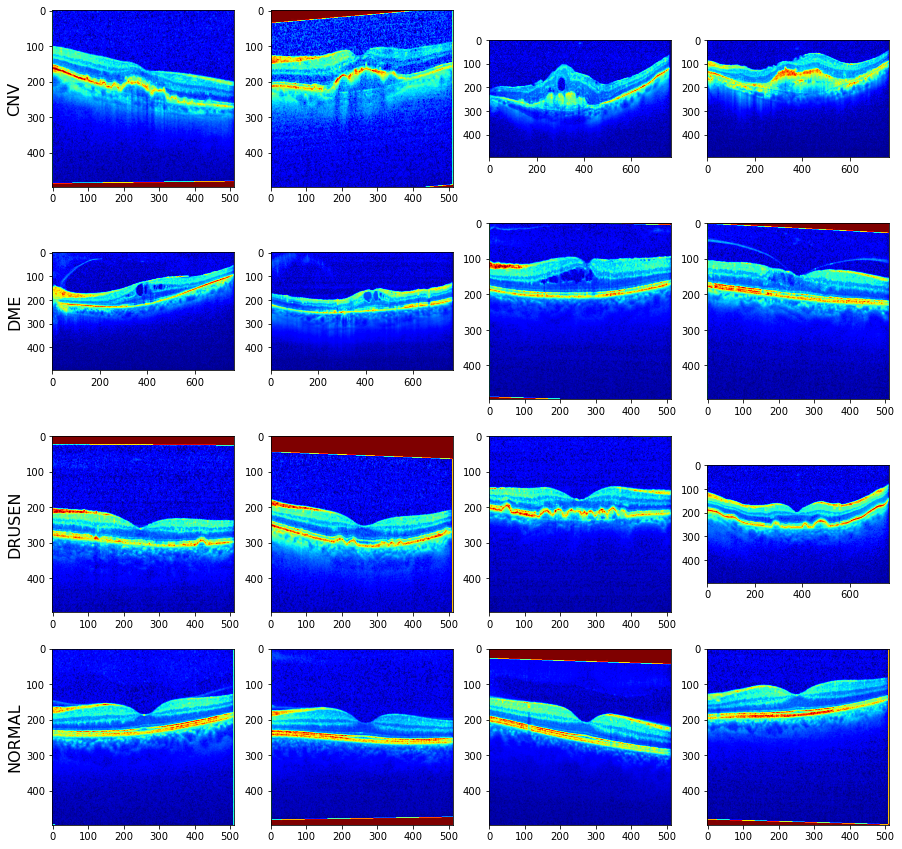

In [2]:
# sneak at the data

train_path = r'../input/kermany2018/OCT2017 /train/'
val_path = r'../input/kermany2018/OCT2017 /val/'
test_path = r'../input/kermany2018/OCT2017 /test/'

classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']


cnv_examples = glob.glob(val_path + 'CNV/*')
dme_examples = glob.glob(val_path + 'DME/*')
drusen_examples = glob.glob(val_path + 'DRUSEN/*')
normal_examples = glob.glob(val_path + 'NORMAL/*')

examples = cnv_examples[:4] + dme_examples[:4] + drusen_examples[:4] + normal_examples[:4]

fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 4
for i in range(columns*rows):
    img = plt.imread(examples[i])
    ax = fig.add_subplot(rows, columns, i+1)
    if i%4==0:
        plt.ylabel(classes[int(i/4)], fontsize=16)
    plt.imshow(img, cmap='jet')
plt.show()



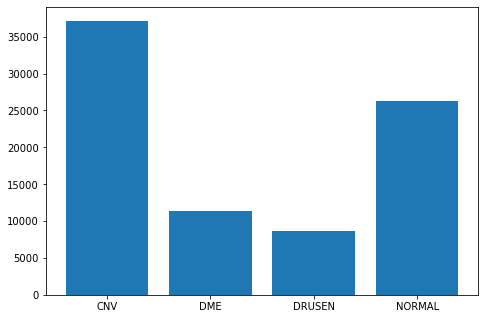

In [3]:
# Imbalance Graph

total_cnv_samples = len(glob.glob(train_path + 'CNV/*'))
total_dme_samples = len(glob.glob(train_path + 'DME/*'))
total_drusen_samples = len(glob.glob(train_path + 'DRUSEN/*'))
total_normal_samples = len(glob.glob(train_path + 'NORMAL/*'))

sample_distribution = [total_cnv_samples, total_dme_samples, total_drusen_samples, total_normal_samples]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes, sample_distribution)
plt.show()

In [4]:
# Initialize the parameters

nh = nw = 150
nc = 3
n_classes = 4

epochs = 10
batch_size = 16

acc_thres = 0.99

learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_data = train_datagen.flow_from_directory(train_path,
                                               target_size=(nh, nw),
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True
                                              )

# Class balancing
counter = Counter(train_data.classes)                          
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     
print(class_weights)


Found 83484 images belonging to 4 classes.
{0: 1.0, 1: 3.2785512865703206, 2: 4.3181290622098425, 3: 1.4138324149724493}


[1.         3.27855129 4.31812906 1.41383241]


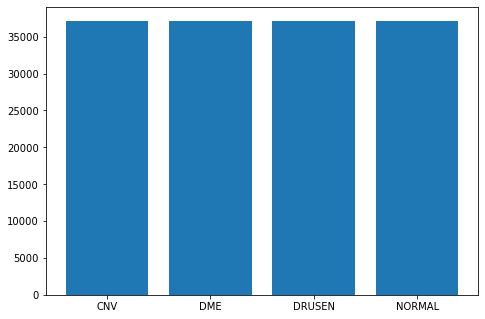

In [6]:
# It does not increase the samples but assign weights to each class which is passed to model.fit to avoid any bias via unbalanced data

cls_wghts = np.fromiter(class_weights.values(), dtype=float)
print(cls_wghts)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes, sample_distribution*cls_wghts)
plt.show()

In [7]:
# Callbacks

def scheduler(epoch, lr):
    if epoch == 1:
        return lr
    elif epoch<=3:
        lr = lr**1.1
    else :
        lr /= 2

    return lr


lr_scheduler = LearningRateScheduler(scheduler) 

class Callbacks(Callback):
#     def on_train_batch_end(self, batch, logs=None):
#         print('For Batch {} : Loss = {:7.2f}, Acc = {:7.2f}'.format(batch,
#                                                                    logs['loss'],
#                                                                    logs['acc']))
    
    def on_epoch_end(self, epoch, logs=None):
        if logs['acc']>acc_thres:
            self.model.stop_training = True
            
            
# tensorboard = TensorBoard(log_dir=r'../logs/retinalOCT_{}'.format(int(time.time())), histogram_freq=1, write_graph=True)

csvlogger = CSVLogger(filename=r'training_{}.log'.format(int(time.time())))



[0.001, 0.000501187233627272, 0.0002344228815319919, 0.00011721144076599595, 5.860572038299798e-05, 2.930286019149899e-05, 1.4651430095749494e-05, 7.325715047874747e-06, 3.6628575239373735e-06, 1.8314287619686868e-06]


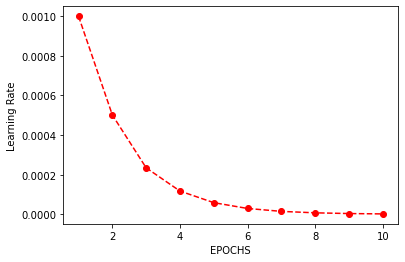

In [8]:
# learning rate ploy

lr_y = []
ep_x = []
lr = learning_rate

for i in range(1, epochs+1):
    lr = scheduler(i, lr)
    lr_y.append(lr)
    ep_x.append(i)

print(lr_y)

plt.plot(ep_x, lr_y, 'ro--')
plt.xlabel('EPOCHS')
plt.ylabel('Learning Rate')
plt.show()


In [9]:
def model_efn():
    input_shape = (150, 150, 3)
    classes = 4
    
    model = efn.EfficientNetB7(weights='imagenet', input_shape=input_shape, pooling='max', include_top=False)
    x = model.output
    output = Dense(classes, activation='softmax')(x)

    return Model(inputs=model.input, outputs=output)

In [10]:
model = model_efn()
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2),
             metrics=['acc']
             )


258441216/258434480 [==============================] - 10s 0us/step


In [11]:

history = model.fit(x=train_data,
                    steps_per_epoch=int(80000//batch_size),
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    class_weight=class_weights,
                    callbacks=[Callbacks(),
                               csvlogger,
                               lr_scheduler]
                   )

model.save_weights('retina_oct_model.h5')

Epoch 1/10
5000/5000 [==============================] - 1725s 345ms/step - loss: 0.6872 - acc: 0.8839 - lr: 5.0119e-04
Epoch 2/10
5000/5000 [==============================] - 1715s 343ms/step - loss: 0.4121 - acc: 0.9296 - lr: 5.0119e-04
Epoch 3/10
5000/5000 [==============================] - 1720s 344ms/step - loss: 0.2427 - acc: 0.9568 - lr: 2.3442e-04
Epoch 4/10
5000/5000 [==============================] - 1721s 344ms/step - loss: 0.1396 - acc: 0.9746 - lr: 1.0162e-04
Epoch 5/10
5000/5000 [==============================] - 1716s 343ms/step - loss: 0.0895 - acc: 0.9829 - lr: 5.0812e-05
Epoch 6/10
5000/5000 [==============================] - 1723s 345ms/step - loss: 0.0608 - acc: 0.9882 - lr: 2.5406e-05
Epoch 7/10
5000/5000 [==============================] - 1719s 344ms/step - loss: 0.0517 - acc: 0.9895 - lr: 1.2703e-05
Epoch 8/10
5000/5000 [==============================] - 1719s 344ms/step - loss: 0.0462 - acc: 0.9907 - lr: 6.3516e-06


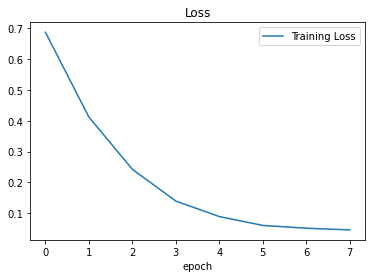

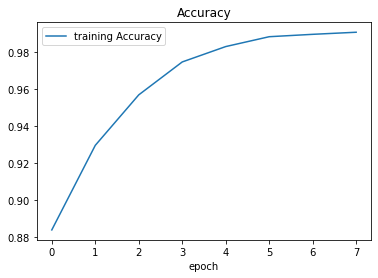

In [12]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.legend(['Training Loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['acc'])
plt.legend(['training Accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [13]:
# test_datagen = ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(test_path,
#                                                   target_size=(150, 150),
#                                                   batch_size=1,
#                                                   class_mode='categorical',
#                                                   shuffle=False
#                                                  ) 

# probabilities = model.predict_generator(test_generator, 968)


In [14]:
test_images_path = glob.glob(test_path + '*/*.jpeg')
x_test = []
y_test = []
for i in range(len(test_images_path)):
    img = cv2.imread(test_images_path[i])
    img = cv2.resize(img, (150,150))
    img = np.array(img/255.0)
    x_test.append(img)
    if 'CNV' in test_images_path[i]:
        y_test.append(0)
    elif 'DME' in test_images_path[i]:
        y_test.append(1)
    elif 'DRUSEN' in test_images_path[i]:
        y_test.append(2)
    elif 'NORMAL' in test_images_path[i]:
        y_test.append(3)
y_test = np.array(y_test)
x_test = np.array(x_test)
print(x_test.shape, y_test.shape)


(968, 150, 150, 3) (968,)


31/31 [==============================] - 4s 125ms/step - loss: 0.0024 - acc: 1.0000
Predicted    0    1    2    3
Actual                       
0          242    0    0    0
1            0  242    0    0
2            0    0  242    0
3            0    0    0  242
Predicted    0    1    2    3
Actual                       
0          1.0  0.0  0.0  0.0
1          0.0  1.0  0.0  0.0
2          0.0  0.0  1.0  0.0
3          0.0  0.0  0.0  1.0


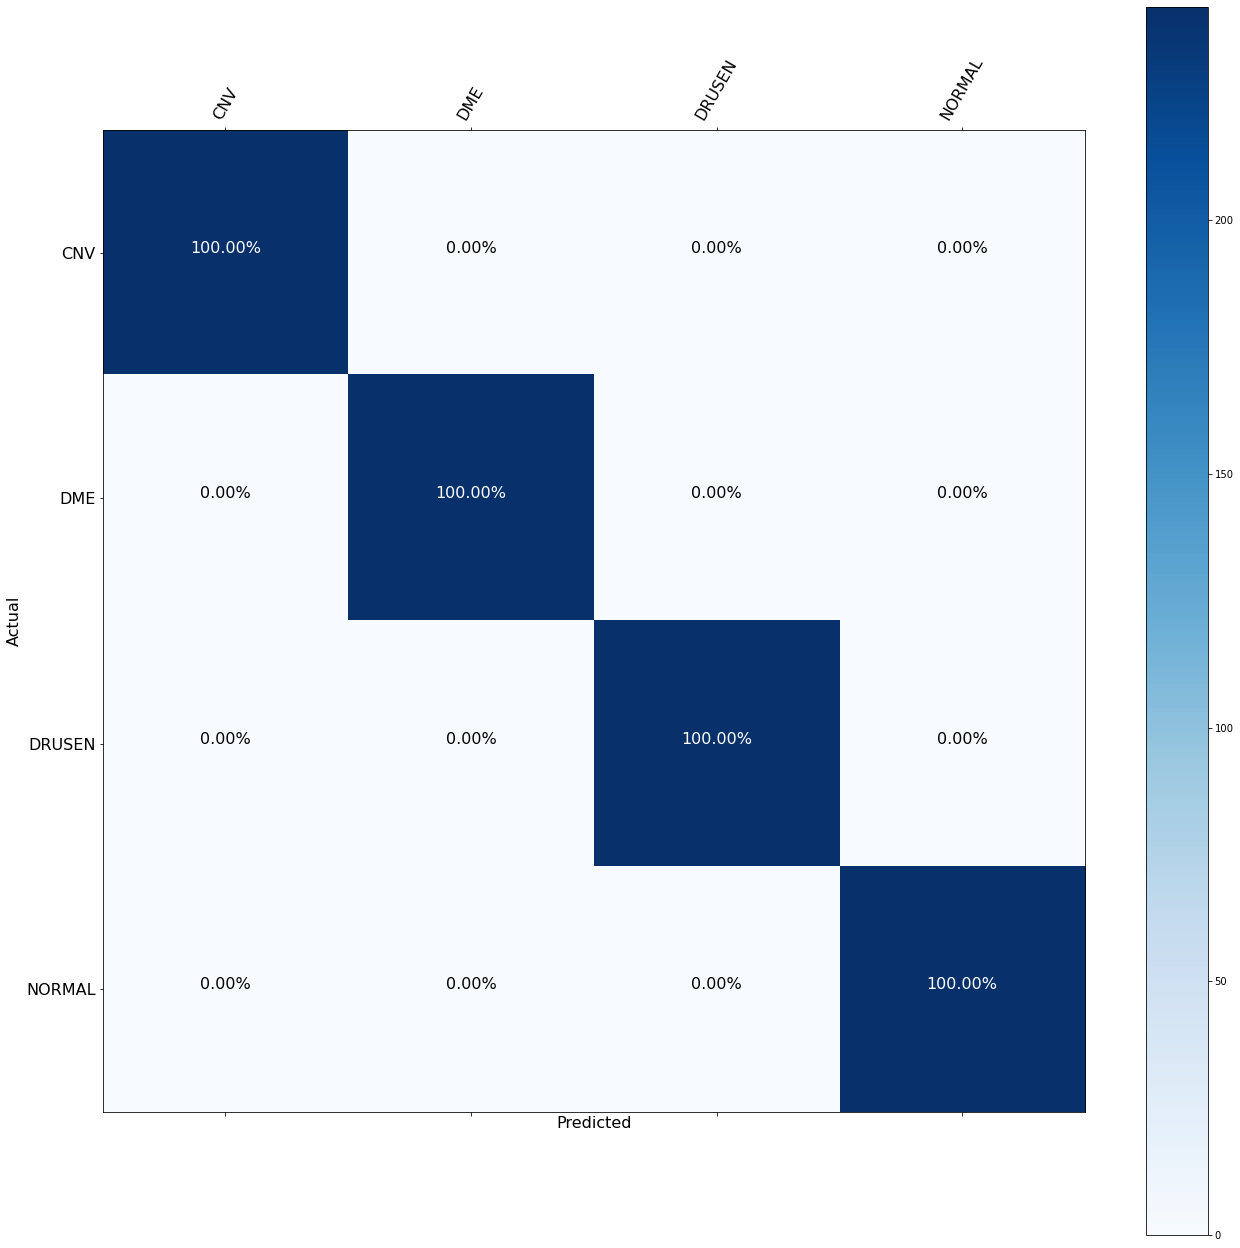

In [23]:
# Confusion Matrix

y_test_cat = tf.keras.utils.to_categorical(y_test)
loss_and_metrics = model.evaluate(x_test, y_test_cat)

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

labels = ('CNV', 'DME', 'DRUSEN', 'NORMAL')

y_actu = pd.Series(y_test, name='Actual')
y_pred = pd.Series(y_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

df_conf_norm = df_confusion / df_confusion.sum(axis=1)
print(df_confusion)
print(df_conf_norm)

plt.figure(figsize=(20, 20))
plt.matshow(df_confusion, cmap=plt.get_cmap('Blues'), fignum=1)  # imshow
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels,fontsize=16, rotation=60)
plt.yticks(tick_marks, labels, fontsize=16)
thresh = 0.6

for i in range(n_classes):
    for j in range(n_classes):
        plt.text(i, j, "{:0.2f}%".format(df_conf_norm[i][j] * 100),
                 horizontalalignment='center',
                 color='white' if df_conf_norm[i][j] > thresh else 'black',
                fontsize = 16)

# plt.tight_layout()
plt.ylabel(df_confusion.index.name, fontsize=16)
plt.xlabel(df_confusion.columns.name,fontsize=16)
plt.show()